***
## IT575: Computational Shape Modeling (Autumn 2024-25)
### Assignment 2: Procrustes Shape Analysis
#### Student 1 Name: Dhruv Shah               Student 1 ID: 202103017
#### Student 1 Name: Vraj Thakkar                 Student 2 ID: 202103040
***

In [1]:
# import useful libraries
import numpy as np
import matplotlib.pyplot as plt
import math

### Q.1. We will study the shape space of rectangles to begin with. Complete the code below to generate a collection of random rectangles - centered at randomly chosen points, in random orientations, and in random aspect ratios.

In [2]:
#############################################
# Random Rectangle Generation
# myRectangle(n) generates 'n' rectangles in 2D with random aspect ratios, orientations and locations.
# It returns two nx4 arrays, each containing x and y coordinates respectively of the 4 vertices (in each row)
# of the 'n' rectangles.
#############################################
def myRectangle(n):
    aspect = np.abs(1 + (20*(np.random.rand(n)-0.5))) # Aspect ratio distribution: |1+ U([-10,10])|
    theta = 2*np.pi * np.random.rand(n)             # Orientation angle dist: U([0,2 pi])
    txtemp = 10*(np.random.rand(n,1) - 0.5)         # x component of translation vector, dist: U([-5,5])
    tytemp = 10*(np.random.rand(n,1) - 0.5)         # y component of translation vector, dist: U([-5,5])
    tx = txtemp @ np.ones((1,4))    # This is required for translating all 4 vertices with the same vector
    ty = tytemp @ np.ones((1,4))    # This is required for translating all 4 vertices with the same vector

    #Initialize all n rectangles as the square: (-0.5,-0.5), (0.5,-0.5),(0.5,0.5),(-0.5,0.5)
    x = np.array([-0.5, 0.5, 0.5, -0.5])
    y = np.array([-0.5, -0.5, 0.5, 0.5])
    x = np.tile(x,(n,1))
    y = np.tile(y,(n,1))
    #------------------------------

    for i in np.arange(n): # For each random rectangle,do the following:

        # Change the aspect ratio using randomly generated "aspect" below
        x[i] = x[i] * aspect[i]
        ########################################################
        # Convert randomly generated angle to Rotation matrix.
        rot = np.array([[np.cos(theta[i]), -np.sin(theta[i])], [np.sin(theta[i]), np.cos(theta[i])]])
        #-----Apply ith rotation matrix to ith rectangle below
        cord = np.row_stack((x[i], y[i]))
        cord = rot @ cord
        x[i] = cord[0,:]
        y[i] = cord[1,:]
        ########################################################
        #------Translate the rotated rectangle using (tx,ty) below
        x[i] = x[i] - tx[i,:].T
        y[i] = y[i] - ty[i,:].T
        ########################################################

    return x,y

### The code below can be used to plot closed and open landmark representations of 2d objects

In [3]:
#################################################################
# Plots collection of 2D shapes
# Input: x,y - x and y coordinate matrices. Expected size n x m, where n is the number of shapes,
#              m is the number of points in each shape
#          t - t=0 plots closed curves by appending first point to the end. Any other value of t plots only
#              the given points.
#          c - Plotting parameters: "." will plot only the given vertices without joining them,
#              "-" will join the points with line segments. Color alphabets can also be provided, i.e.
#              "k-" will plot the points in black and will join them with black line segments.
# Output: None
# Usage: myplot2dshapes(x,y,0,"b.")
#################################################################
def myplot2dshapes(x,y,t,c):
    xs = x.shape
    n = xs[0]
    x1 = x
    y1 = y
    # fig1, ax = plt.subplots()
    # ax.set_box_aspect(1)
    if t==0:
        if len(xs)<2:
            x1 = np.append(x,x[0])
            y1 = np.append(y,y[0])
            plt.plot(x1,y1,c)
            plt.axis('square')

        else:
            x1 = np.c_[x1, x1[:,0]]
            y1 = np.c_[y1, y1[:,0]]
            for i in np.arange(n):
                plt.plot(x1[i,:],y1[i,:],c)
                plt.axis('square')

    else:
        if len(xs)<2:
            plt.plot(x1,y1,c)
            plt.axis('square')

        else:
            for i in np.arange(n):
                plt.plot(x1[i,:],y1[i,:],c)
                plt.axis('square')


    plt.grid()

Text(0.5, 1.0, 'Random Rectangles')

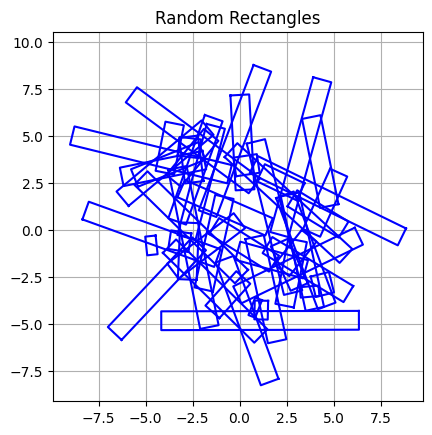

In [4]:
x, y = myRectangle(50) # Generate 50 random rectangles
myplot2dshapes(x,y,0,"b-")
plt.title('Random Rectangles')

### Q.2. Complete the code below to align a given collection of shapes to another given shape.
#### Align all shapes so that their centroids lie on origin and all shapes are unit-sized.

In [5]:
#############################################
# Procrustes Alignment of collection of shapes (x,y) to a given shape (x0,y0)
# Input: x0, y0 - Expected Shape 1 x m, where m is the number of points in the shape
#        x, y - Collection of shapes to be aligned with x0,y0. x.shape = (n,m), y.shape = (n,m),
#               where n is the number of the shapes to be aligned with (x0,y0)
# Output: xtso,ytso - Shapes aligned with (x0,y0) with centroids of all of them at origin.
#                     xtso.shape = (n,m), ytso.shape(n,m).
#                     xtso contains x coordinates, while ytso contains y coordinates.
#############################################
def myProcrustes(x0,y0,x,y):
    n = np.shape(x)[0] # Number of shapes
    m = np.shape(x)[1] # Number of points in each shape

    #---Translate x0,y0 so that its centroid aligns with origin.
    x0 = x0 - (np.mean(x0, axis=0) * np.ones((1,m)))
    y0 = y0 - (np.mean(y0, axis=0) * np.ones((1,m)))

    #---- Scale x0,y0 to unit size
    s0 = (((x0**2) + (y0**2))@ np.ones((m,1)))**(-0.5)
    x0 = s0*x0
    y0 = s0*y0

    #---- Initialze the aligned shapes
    xt = np.empty((n,m))
    yt = np.empty((n,m))
    xts = np.empty((n,m))
    yts = np.empty((n,m))

    #--- Translate each shape so that its centroid aligns with origin.
    for i in range(n):
        xt[i,:] = x[i,:] - (np.mean(x[i,:], axis=0) * np.ones((1,m)))
        yt[i,:] = y[i,:] - (np.mean(y[i,:], axis=0) * np.ones((1,m)))

    #--- Scale them to unit size
    for i in range(n):
        s = 0
        s = (((xt[i,:]**2) + (yt[i,:]**2))@ np.ones((m,1)))**(-0.5)
        xts[i,:] = s*xt[i,:]
        yts[i,:] = s*yt[i,:]


    c1 = x0 + 1j * y0
    theta = np.zeros(n) # Angle by which to rotate each shape in x,y. Initialized as 0.
    xtso = xts # Final aligned shape's x coordinate initialized as xts
    ytso = yts # Final aligned shape's y coordinate initialized as yts

    for i in np.arange(n): # For each of the shape
        # Estimate the angle of rotation
        c2 = xts[i, :] + 1j * yts[i, :]
        theta[i] = np.angle(np.vdot(c2, c1))
        ################################
        rot = np.array([[np.cos(theta[i]), -np.sin(theta[i])], [np.sin(theta[i]), np.cos(theta[i])]])
        tloc = np.array([xts[i,:],yts[i,:]])
        temp = rot @ tloc
        xtso[i,:] = temp[0,:]
        ytso[i,:] = temp[1,:]
    return xtso,ytso

### Q.3. Complete the following code to compute the mean shape from a collection of given shapes.

#### You may either use the algorithm described in class, or follow the iterative process below:
#### 1. Initialize the mean shape by randomly choosing a shape from the given collection
#### 2. Align all ORIGINAL shapes to the current estimate of mean shape
#### 3. Obtain new estimate of mean by taking mean of the aligned coordinates
#### 4. If the change of mean shape is below a threshold, stop and return the latest estimate of mean shape.
#### 5. Otherwise, go to Step 2.

In [6]:
#############################################
# Compute Procrustes Mean Shape
# Input: x,y - Collection of n shapes, each with m points. Size of x and y is n x m.
# Ouput: xm, ym - x and y coordinates of the estimated mean. Each of these array has size 1 x m.
#############################################

# In the below code we have implemented the above stated iterative procedure.
def myprocrustesmean(x,y):
    n = x.shape[0]
    r_idx = np.random.randint(0, n)

    #-- Initialize a random shape as mean shape
    xm_r = x[r_idx, :]
    ym_r = y[r_idx, :]
    max_iter = 0
    diff = 1

    # The iterative procedure is implemented.
    while(diff > 0.001 and max_iter<=1000):
          xst, yst = myProcrustes(xm_r, ym_r, x, y)
          xm = np.mean(xst, axis=0)
          ym = np.mean(yst, axis=0)
          s  = (xm**2 + ym**2)**(-0.5)
          xk = s*xm
          yk = s*ym
          mu0 = xm_r + 1j * ym_r
          mu1 = xm + 1j * ym
          diff = np.linalg.norm(mu1 - mu0)
          max_iter+=1
    return xm,ym

### Q.4. Complete the code below to compute the Principal Shape variations.

In [7]:
#############################################
# Compute Principal shape variations
# Input: x,y - Collection of n shapes, each with m points. Size of x and y is n x m.
#        xm,ym - x and y coordinates of the estimated mean. Each of these array has size 1 x m.
# Output: evalue, evec - evalue contains the amount of variation of shape along corresponding directions
#                        given in evec. evalue is given in descending order
#############################################
def myShapevar(x,y,xm,ym):
    x,y = myProcrustes(xm,ym,x,y) # Align entire collection of shape with mean shape.
    ###### Form the Shape Covariance Matrix below. Denote it as C.
    x = x - xm*np.ones((x.shape[0],1))
    y = y - ym*np.ones((y.shape[0],1))
    cp = x + 1j*y
    C = (cp.conj().T @ cp)
    evalue, evec = np.linalg.eigh(C)
    evalue = evalue[n::-1]
    evec = evec[:,n::-1]
    return evalue,evec

## Q.5. Perform Shape Analysis of Random Rectangles. What are your observations?

<Figure size 640x480 with 0 Axes>

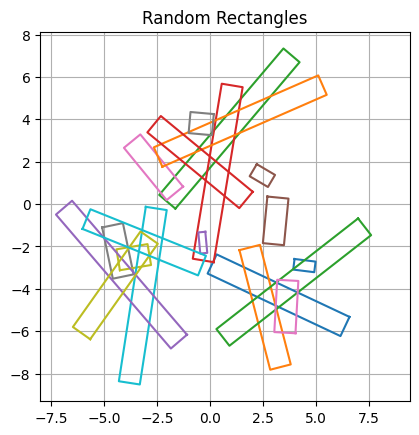

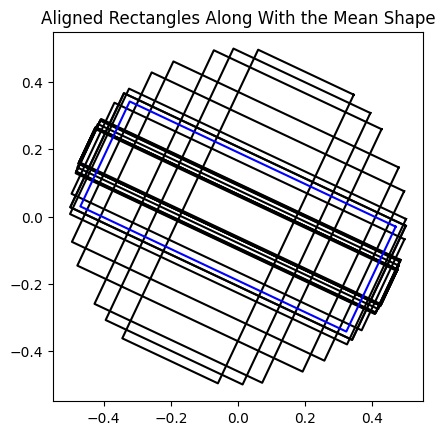

<Figure size 640x480 with 0 Axes>

In [26]:
n = 20 # Number of rectangles
x,y = myRectangle(n) # Generate n random rectangles
myplot2dshapes(x,y,0,"-") # Plot the rectangles
plt.title('Random Rectangles')
xm,ym = myprocrustesmean(x,y) # Compute Procrustes Mean
xa,ya = myProcrustes(xm,ym,x,y) # Align the shape collection with the computed mean
plt.figure() # New figure
myplot2dshapes(xa,ya,0,"k-") # Plot the aligned shape
myplot2dshapes(xm,ym,0,"b-") # Plot the mean shape
plt.title('Aligned Rectangles Along With the Mean Shape')
plt.figure()

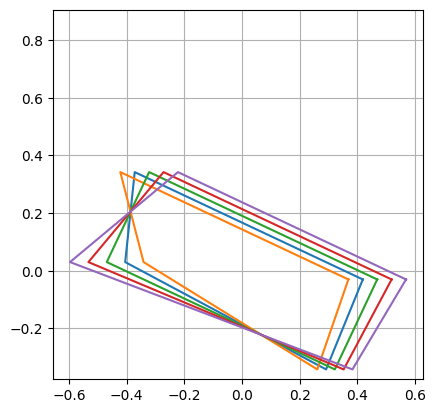

In [27]:
##### Principal Shape Variations
Var,Dir = myShapevar(xa,ya,xm,ym)
### Write your code to plot mean, mean + 0.1 Dir_1,mean + 0.2 Dir_1, mean - 0.1 Dir_1, mean - 0.2 Dir_1
Cm = xm + 1j*ym
num = [0.1,0.2,0,-0.1,-0.2]
Cm_all = []
for k in num:
    Cm_all.append(Cm + k*Dir[0])
for k in Cm_all:
    myplot2dshapes(k.real,k.imag,0,"-")

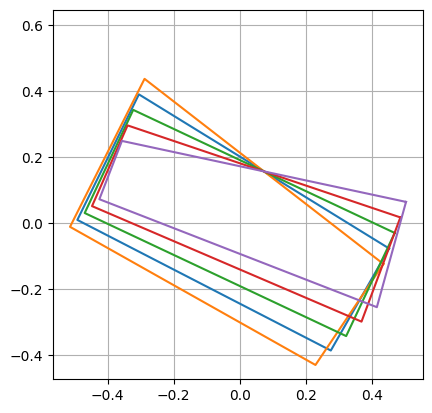

In [28]:
### Write your code to plot mean, mean + 0.1 Dir_2,mean + 0.2 Dir_2, mean - 0.1 Dir_2, mean - 0.2 Dir_2
Cm_all = []
for k in num:
    Cm_all.append(Cm + k*Dir[1])
for k in Cm_all:
    myplot2dshapes(k.real,k.imag,0,"-")

####  Record your observations in this cell. Interpret the directions of shape variations

If we look at the portions of the quadrilaterals generated by mean + Dir[i] then we see that their sides are closer in the direction where we have less variance and the distance between the sides of the quadrilaterals(by mean + Dir[i]) increases as the underlying distribution of shape varies more in that direction. Once the shapes are aligned after procustes alignment then Dir[0] will be the direction where there is maximum variance in the shapes(or the procustes aligned coordinates) of the underlying distribution.

### Q.6. Perform Shape Analysis of Jawlines of Helen Dataset
### Source of data: http://www.ifp.illinois.edu/~vuongle2/helen/

<Figure size 640x480 with 0 Axes>

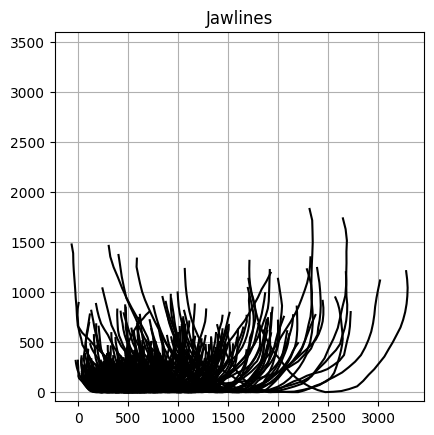

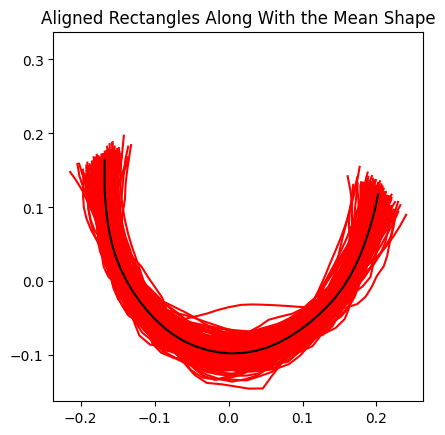

<Figure size 640x480 with 0 Axes>

In [29]:
x = np.load('arr_0.npy')
y = np.load('arr_1.npy')
###### Repeat the same exercise with the Jawlines data. There are 300 jawlines,
###### where each jawline has 41 points in it. Note the the jawline should be shown as an open curve
###### (t=1 in myplot2dshapes). Compute the mean shape and principal shape variations.

myplot2dshapes(x,y,1,"k-") # Plot the rectangles
plt.title('Jawlines')
plt.figure()
xm_new,ym_new = myprocrustesmean(x,y) # Compute Procrustes Mean
xa,ya = myProcrustes(xm_new,ym_new,x,y) # Align the shape collection with the computed mean
myplot2dshapes(xa,ya,1,"r-") # Plot the aligned shape
myplot2dshapes(xm_new,ym_new,1,"k-") # Plot the mean shape
plt.title('Aligned Rectangles Along With the Mean Shape')
plt.figure()


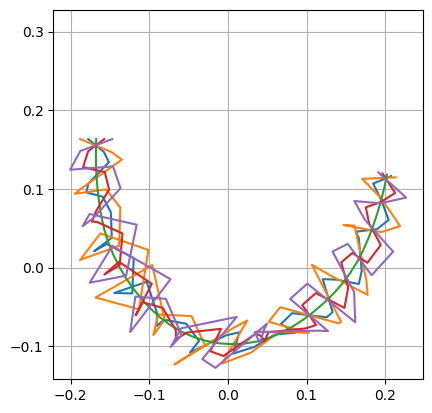

In [31]:
Var_new, Dir_new = myShapevar(xa,ya,xm_new,ym_new)
### Write your code to plot mean, mean + 0.1 Dir_1,mean + 0.2 Dir_1, mean - 0.1 Dir_1, mean - 0.2 Dir_1
num = [0.1,0.2,0,-0.1,-0.2]
Cm_new = xm_new + 1j*ym_new
Cm_all_new = []
for k in num:
    Cm_all_new.append(Cm_new + k*Dir_new[:,0])
for k in Cm_all_new:
    myplot2dshapes(k.real,k.imag,1,"-")

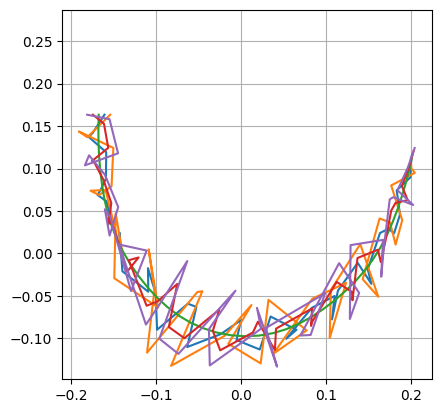

In [32]:
num = [0.1,0.2,0,-0.1,-0.2]
Cm_new = xm_new + 1j*ym_new
Cm_all_new = []
for k in num:
    Cm_all_new.append(Cm_new + k*Dir_new[:,1])
for k in Cm_all_new:
    myplot2dshapes(k.real,k.imag,1,"-")

####  Record your observations for Q.6 in this cell. Interpret the directions of shape variations
***

Here too we observe that the variations in the newly obtained shapes is much more prominent in the one with Dir[0] as it is the direction of maximum variance. Individually we can observe that the landmark points in these plots have maximum variance from the mean as k is changed from -0.2 to 0.2. This pattern continues to decrease, the variance becomes less pronounced and shapes become more nearer to the mean as the dir is changed(Dir[1]).